# Jordan Red Wine Quality Ensemble Models
**Author:** Jordan  
**Date:** November 21, 2025 <br>
**Objective:** Train and evaluate Gradient Boosting and AdaBoost endsemble models.


## Introduction
In this project, we use the UCI Red Wine Quality dataset. We will preprocess the data and train Gradient Boosting and AdaBoost classifier ensemble models using features based on physicochemical tests to predict the wine quality rating given by wine tasters.  Then, we will give comparisons of the models to each other and the models obtained from other team members.

## Imports
First, we import the necessary Python libraries for our analysis. 

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from statsmodels.stats.stattools import medcouple

from stats_jordan import tukey_fences


## Section 1. Load and Inspect the Data

### 1.1 Load the Dataset
Next, we load the Insurance dataset into a dataframe and call the .info() and .head() methods to view the structure and initial rows of our data.

In [41]:
insurance_df = pd.read_csv("data/insurance.csv")
insurance_df.info()
insurance_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Preliminary Inspection

Now, we check data types, view summary statistics, and check for missing values.

In [42]:
insurance_df.info()
display(insurance_df.describe().round(2))
display(insurance_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Reflection 1

1) What do you notice about the dataset?

    The domain of our dataset is inclusive for only adults, with the age range of 18 to 64 years and a mean age of 39 years.  Body Mass Index ranges from 15.96 to 53.13 with an average of 30.66, placing the average person in our dataset in the obese category.  The number of children per person ranges from 0 to 5 with a mean of 1.09 and a notable upper-quartile of 2 children.  Charges billed by health insurance for the individuals range from $1,121.87 to $63,770.43 with an average charge of $13,270.42. 
2) Are there any data issues?

    We notice that the standard deviation for age is moderately high at 14.05 years relative to the mean age of 39.21 years.  The standard deviations for children and charges are very high at 1.21 children and $12,220.01 respectively relative to the respective means of 1.09 years and $13,270.42.  The high variability in theses features suggests a higher possibility of outliers and skewed features.

## Section 2. Data Exploration and Preparation

### 2.1 Explore Data Patterns and Distributions

Create histograms, boxplots, and count plots for categorical variables (as applicable).
Identify patterns, outliers, and anomalies in feature distributions.
Check for class imbalance in the target variable (as applicable).

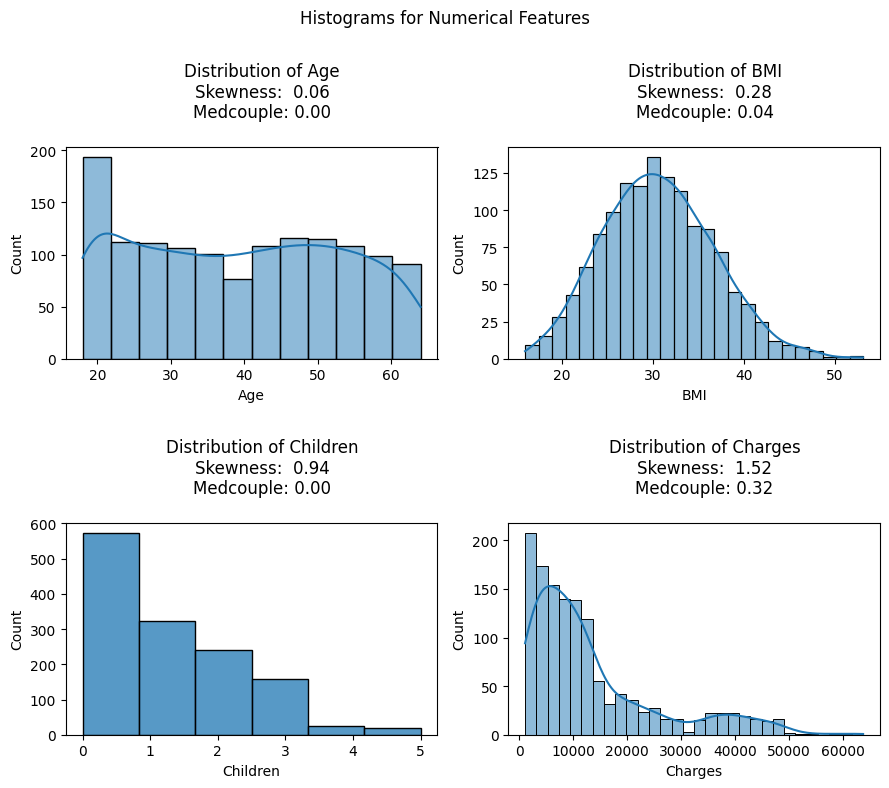

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(9,8))

for ax, col in zip(axes.flatten(), ["age", "bmi", "children", "charges"], strict=True):

    if col == "children":
        sns.histplot(insurance_df[col], kde=False, ax=ax, bins=6) # type: ignore
    else:
        sns.histplot(insurance_df[col], kde=True, ax=ax) # type: ignore

    ax.set_title(f"""
    Distribution of {"BMI" if col == "bmi" else col.title()}
    Skewness:  {insurance_df[col].skew():.2f}
    Medcouple: {medcouple(insurance_df[col]):.2f}
    """)
    ax.set_xlabel("BMI" if col == "bmi" else col.title())

fig.suptitle("Histograms for Numerical Features")
plt.tight_layout()
plt.show()

In [44]:
results_dict = {}
total = len(insurance_df)

for col in ["age", "bmi", "children", "charges"]:

    fences = tukey_fences(insurance_df[col], adjusted = col == "charges")
    outlier = (insurance_df[col] < fences.inner_lower) | (insurance_df[col] > fences.inner_upper)
    extreme_outlier = (insurance_df[col] < fences.outer_lower) | (insurance_df[col] > fences.outer_upper)
    results_dict[col] = {
        "Percentage Outliers": round((outlier.sum() / total) * 100, 2),
        "Percentage Extreme Outliers": round((extreme_outlier.sum() / total) * 100, 2)
    }

display(pd.DataFrame(results_dict))

,age,bmi,children,charges
Percentage Outliers,0.0,0.67,0.0,0.0
Percentage Extreme Outliers,0.0,0.00,0.0,0.0


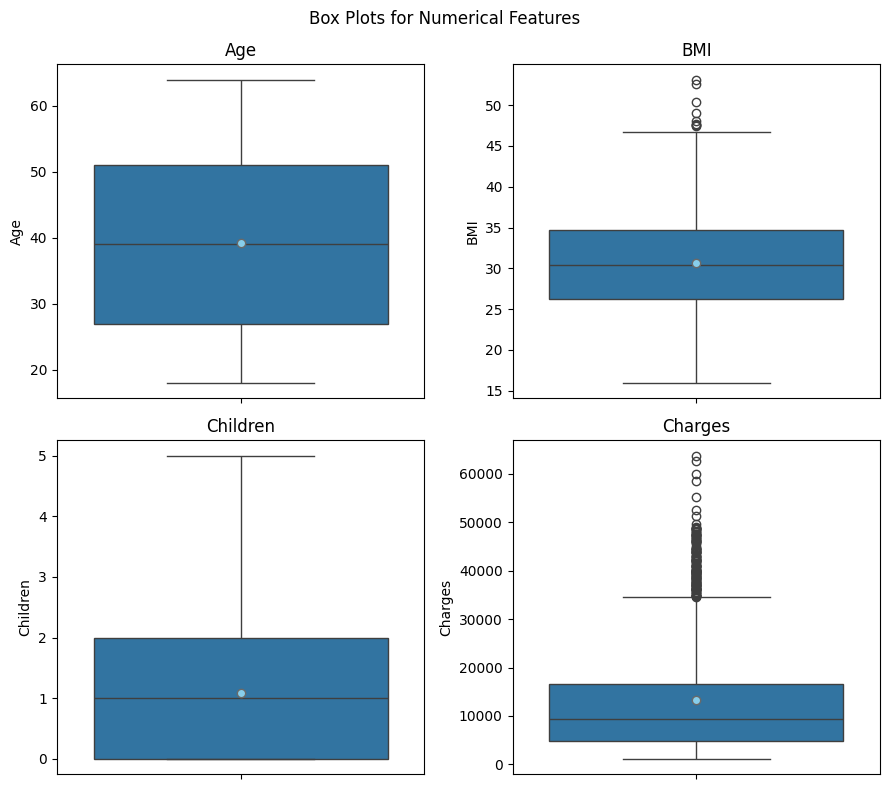

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(9,8))

for ax, col in zip(axes.flatten(), ["age", "bmi", "children", "charges"], strict=True):

    sns.boxplot(y=insurance_df[col], ax=ax, showmeans=True,
                meanprops={"marker":"o", 
                           "markerfacecolor":"skyblue", 
                           "markeredgecolor":"dimgray",
                           "markersize":"6"})
    ax.set_title("BMI" if col == "bmi" else col.title())
    ax.set_ylabel("BMI" if col == "bmi" else col.title())

fig.suptitle("Box Plots for Numerical Features")
plt.tight_layout()
plt.show()

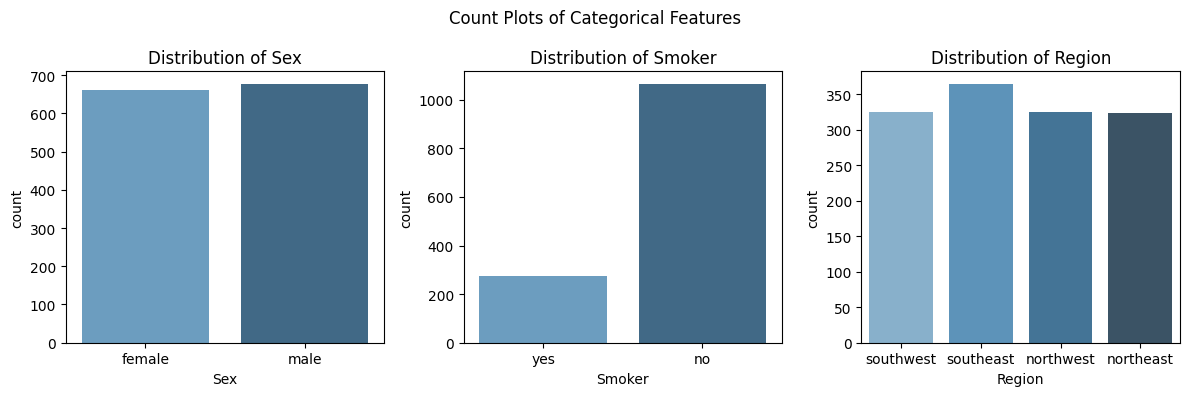

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, ["sex", "smoker", "region"], strict=True):
    sns.countplot(x=col, data=insurance_df, ax=ax, hue=col, palette="Blues_d")
    ax.set_title(f"Distribution of {col.title()}")
    ax.set_xlabel(f"{col.capitalize()}")

fig.suptitle("Count Plots of Categorical Features")
plt.tight_layout()
plt.show()

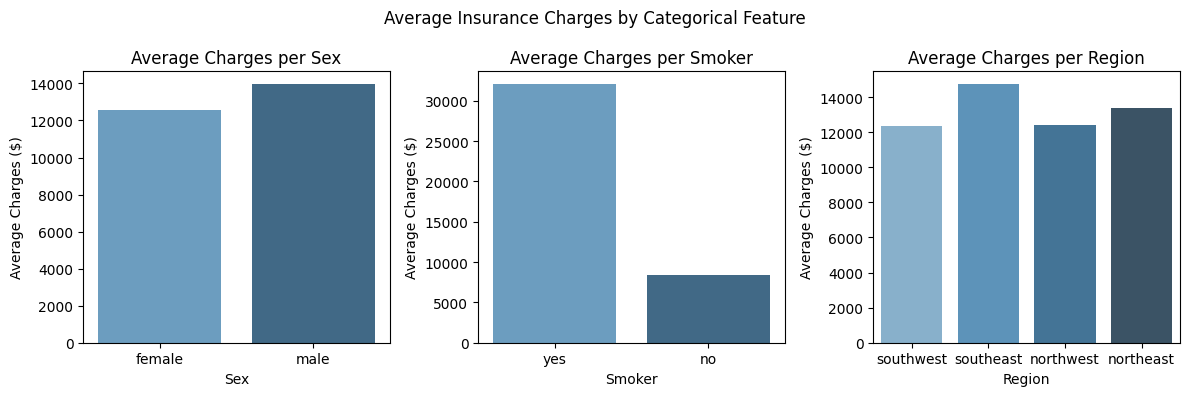

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, ["sex", "smoker", "region"], strict=True):

    sns.barplot(x=col, y="charges", data=insurance_df, ax=ax, hue=col, palette="Blues_d", errorbar=None)
    ax.set_title(f"Average Charges per {col.capitalize()}")
    ax.set_ylabel("Average Charges ($)")
    ax.set_xlabel(f"{col.capitalize()}")

fig.suptitle("Average Insurance Charges by Categorical Feature")
plt.tight_layout()
plt.show()

### 2.2 Handle Missing Values and Clean Data

Impute or drop missing values (as applicable).
Remove or transform outliers (as applicable).
Convert categorical data to numerical format using encoding (as applicable).

In [ ]:
bmi_fences = tukey_fences(insurance_df["bmi"])
bmi_outliers = (insurance_df["bmi"] < bmi_fences.inner_lower) | (insurance_df["bmi"] > bmi_fences.inner_upper)
cleaned_df = insurance_df.drop(insurance_df[bmi_outliers].index)

cleaned_df["smoker"] = cleaned_df["smoker"].map({"yes": 1, "no": 0})
cleaned_df["sex"] = cleaned_df["sex"].map({"male": 1, "female": 0})

region_dummies = pd.get_dummies(cleaned_df["region"], dtype=int, drop_first=True)
cleaned_df = pd.concat([cleaned_df, region_dummies], axis=1)
cleaned_df.drop("region", axis=1, inplace=True)

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
count,1329.00,1329.0,1329.00,1329.00,1329.0,1329.00,1329.00,1329.00,1329.00
mean,39.20,0.5,30.54,1.10,0.2,13212.33,0.24,0.27,0.24
std,14.05,0.5,5.92,1.21,0.4,11997.24,0.43,0.44,0.43
min,18.00,0.0,15.96,0.00,0.0,1121.87,0.00,0.00,0.00
25%,27.00,0.0,26.22,0.00,0.0,4738.27,0.00,0.00,0.00
50%,39.00,1.0,30.30,1.00,0.0,9361.33,0.00,0.00,0.00
75%,51.00,1.0,34.48,2.00,0.0,16586.50,0.00,1.00,0.00
max,64.00,1.0,46.75,5.00,1.0,62592.87,1.00,1.00,1.00


### 2.3 Feature Selection and Engineering

Create new features (as applicable).
Transform or combine existing features to improve model performance (as applicable).
Scale or normalize data (as applicable).

### Reflection 2

1) What patterns or anomalies do you see?
2) Do any features stand out?
3) What preprocessing steps were necessary to clean and improve the data?
4) Did you create or modify any features to improve performance?

## Section 3. Feature Selection and Justification

### 3.1 Choose Features and Target

Select two or more input features (numerical for regression, numerical and/or categorical for classification)
Select a target variable (as applicable)
Regression: Continuous target variable (e.g., price, temperature).
Classification: Categorical target variable (e.g., gender, species).
Clustering: No target variable.
Justify your selection with reasoning.

### 3.2 Define X and y

Assign input features to X
Assign target variable to y (as applicable)

### Reflection 3

1) Why did you choose these features?
2) How might they impact predictions or accuracy?

## Section 4. Train Linear Regression Model

### 4.1 Split Data

### 4.2 Train the Model

### 4.3 Evaluate Performance

Regression: R^2, MAE, RMSE (RMSE has been recently updated)

### Reflection 4

1) How well did the model perform?
2) Any surprises in the results?

## Section 5. Improve the Model or Try Alternatives

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression

### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression

### 5.3 Compare Model Performance

### Reflection 5

1) Which models performed better?
2) How does scaling impact results?

## Section 6. Final Thoughts & Insights

### 6.1 Findings Summary


### 6.2 Challenges Faced

### 6.3 Next Steps